In [1]:
from brian2 import *
from brian2tools import *
import numpy as np
import matplotlib.pyplot as plt

In [2]:
path_to_data = 'data/mnist_reduced.pkl.gz'

In [3]:
# Functions: 

def exp_prob_beta_gamma(dt, beta, g_leak, gamma, t_ref):
    def func(V):
        return np.random.rand( len(V) ) < (1-np.exp(-np.exp(V*beta*g_leak+np.log(gamma))*float(dt)))
    return func

def load_mnist_data(min_p = 1e-4, max_p=.95, binary=False, seed=None, n_classes = range(10)):
    #------------------------------------------ Create Input Vector
    
    mnist_data = load_MNIST(n_samples,
                            min_p = min_p,
                            max_p = max_p,
                            binary = binary,
                            seed = seed, 
                            num_classes = n_classes)
    iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = mnist_data
    return iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l

def bound_data(data, min_p = 0.0001, max_p = .95, binary = False):
    if not binary:
        max_p_ = max_p
        min_p_ = min_p
    else:
        max_p_ = 0.5
        min_p_ = 0.5
    data[data >= max_p_] = max_p
    data[data < min_p_] = min_p
    
def select_equal_n_labels(n, data, labels, classes = None, seed=None):
    if classes is None:
        classes = range(10)    
    n_classes = len(classes)
    n_s = np.ceil(float(n)/n_classes)
    max_i = [np.nonzero(labels==i)[0] for i in classes]
    if seed is not None:
        np.random.seed(seed)
    f = lambda x, n: np.random.randint(0, int(x)-1, int(n))
    a = np.concatenate([max_i[i][f(len(max_i[i]), n_s)] for i in classes])
    np.random.shuffle(a)
    iv_seq = data[a]
    iv_l_seq = labels[a]
    return iv_seq, iv_l_seq   

def load_MNIST(n_samples, min_p = 0.0001, max_p = .95, binary = False, seed=None, datafile = path_to_data, num_classes = range(10)):
    import gzip, pickle
    mat = pickle.load(gzip.open(datafile, 'r'), encoding='latin1')

    train_iv = mat['train']
    train_iv_l = mat['train_label']
    test_iv = mat['test']
    test_iv_l = mat['test_label']
    
    bound_data(train_iv, min_p, max_p, binary)
    bound_data(test_iv, min_p, max_p, binary)
    
    iv_seq, iv_l_seq = select_equal_n_labels(n_samples, train_iv, train_iv_l, seed = seed, classes=num_classes)
    
    return iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l

def clamped_input_transform(input_vector, min_p=1e-7, max_p=0.999):
    s = np.array(input_vector) #Divide by t_ref to get firing rates
    s[s<min_p] = min_p
    s[s>max_p] = max_p
    s =  -np.log(-1+1./(s))
    return s

def create_pId(iv_seq, iv_l_seq, N_v, N_c, n_c_unit, min_p = .00001, max_p = .95):
    Id = np.ones([iv_seq.shape[0], iv_seq.shape[1]+N_c])*min_p
    
    for i in range(iv_seq.shape[0]):
        cl = np.zeros(N_c)
        cl[int(iv_l_seq[i]*n_c_unit):int((iv_l_seq[i]+1)*n_c_unit)] = max_p
        Id[i,N_v:] = clamped_input_transform(cl, min_p = min_p, max_p = max_p)
        Id[i,:N_v] = clamped_input_transform(iv_seq[i,:], min_p = min_p, max_p = max_p)

    return Id

def create_Id(data = True, c_min_p = 1e-4, c_max_p = .95, seed = None):
    if hasattr(data, '__len__'):
        iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = data
        Idp = create_pId(iv_seq, iv_l_seq, N_v, N_c, n_c_unit, min_p = c_min_p, max_p = c_max_p)
        Id = (Idp /beta)
    elif data == True:
        iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = load_mnist_data(seed = seed)
        Idp = create_pId(iv_seq, iv_l_seq, N_v, N_c, n_c_unit, min_p = c_min_p, max_p = c_max_p)
        Id = (Idp /beta)
    else:
        Id = np.zeros([n_samples,N_v+N_c])  
    return Id

def classification_free_energy(Wvh, Wch, b_h, b_c, test_data, test_labels, n_c_unit, n_classes = 10):
    numcases = len(test_labels);
    F = np.zeros([int(numcases), int(n_classes)]);
    for i in range(n_classes):
        X= np.zeros([int(numcases), int(n_c_unit)*int(n_classes)]);
        X[:, int(n_c_unit*i):int(n_c_unit*(i+1))] = 1;
        F[:,i] = np.tile(b_c[i],numcases)*X[:,i]+\
                 np.sum(np.log(np.exp(np.dot(test_data, Wvh)+np.dot(X,Wch)+np.tile(b_h,numcases).reshape(numcases,-1))+1), axis=1);
    prediction= np.argmax(F, axis=1);
    accuracy = sum(prediction==test_labels)/numcases # changed from: 1-float(sum(prediction!=test_labels))/numcases
    assert 1>=accuracy>=.1/n_classes
    return accuracy, prediction!=test_labels

def monitor_to_spikelist(Ms):
    if len(Ms.spikes)>0:
        s = np.array(Ms.spikes)
        id_list = range(len(Ms.source))
        s[:,1] = s[:,1] * 1000 #SpikeList takes ms
        return spikes.SpikeList(spikes = s, id_list = id_list)
    else:
        return spikes.SpikeList(id_list = id_list)

def custom_step(clock_object):
    tmod_now, n_now = clock_object.tmod, clock_object.n
    clock_object.tmod = np.mod(clock_object.tmod+1, clock_object.mod)
    clock_object.n = int(clock_object.t/(clock_object.period))
    return tmod_now, n_now

def create_bias_vectors(N_v, N_c, N_h):
    bias_v = b_v = np.zeros(N_v)
    bias_h = b_h = np.zeros(N_h)
    bias_c = b_c = np.zeros(N_c)
    return b_v, b_c, b_h    

def create_weight_matrix(N_v, N_h, N_c, sigma = 0.1):
    return np.random.normal(0, sigma, size=(N_v+N_c, N_h))

def create_rbm_parameters(wmean=0, b_vmean=0, b_hmean=0):
    #------------------------------------------ Bias and weights
    b_v, b_c, b_h = create_bias_vectors(N_v, N_c, N_h)
    Whv = create_weight_matrix(N_v, N_h, N_c, sigma = 0.1)    
    Whv+= wmean
    b_v+= b_vmean
    b_h+= b_hmean
    return Whv, b_v, b_c, b_h

def visualise_connectivity(S):
    Ns = 20 # len(S.source)
    Nt = 20 # len(S.target)
    figure(figsize=(10, 4))
    subplot(121)
    plot(zeros(Ns), arange(Ns), 'ok', ms=10) 
    plot(ones(Nt), arange(Nt), 'ok', ms=10) 
    for i, j in zip(S.i[0:20], S.j[0:20]):
        plot([0, 1], [i, j], '-k')
    xticks([0, 1], ['Source', 'Target'])
    ylabel('Neuron index')
    xlim(-0.1, 1.1)


Main parameters

In [4]:
# Parameters: 

n_classes = 10
N_v = N_inputs =784
N_c = N_class = 40
N_h = N_hidden =500

n_c_unit =  N_c/n_classes

dcmt = 35 #35 #duty cyle in multiples of t_ref

#----------------------------------------- Neuron parameters
t_ref = 0.004 * second
t_sim = dcmt*t_ref*500    #originally: *10000 # second
bias_input_rate = 1000. * Hz
beta = 2.04371561e+09 # 1/amp
gamma = np.exp(9.08343441e+00)* Hz
tau_noise = .001 * ms
tau_rec = t_ref
theta = .1 * volt 
Cm = 1e-12 * farad
beta_fi = 1./cm/theta
sigma = 1.e-9 * amp  # --> is this the reason for it being slow? Probably this!! sigma = 1.e-9 * amp (is this meant for weight creation?) - seems to be at optimal value
cal_i_lk = 0.0e-10
g_leak = 1e-9 * siemens
#dt = 0.00005 * second # --> is this the reason for it being slow?
n_samples = t_sim/(dcmt*t_ref)+1
#sigma = 4.24e-11 * amp # --> is this the reason for it being slow? Probably this!! originally wnsigma for equations

t_burn_percent = 10.
tau_learn = t_ref

deltaT = ((0.49-t_burn_percent/100)*dcmt*t_ref)

eta = 32e-3
epsilon = eta/beta*t_ref**2
epsilon_bias = eta/beta*t_ref*(1./bias_input_rate)

deltaA  = eta/beta/tau_learn/deltaT*t_ref**2/2
deltaAbias = eta/beta/tau_learn/deltaT*t_ref*(1./bias_input_rate)/2 

i_inj = (- np.log(float(gamma))
         - np.log(float(t_ref))
         )/beta * amp

#defaultclock.dt = dt # --> is this the reason for it being slow?



In [5]:
mnist_data = load_mnist_data(min_p = .00001, max_p = .98, binary = True, seed=0#, n_classes=range(1)
                             )

In [6]:
Id = create_Id(mnist_data, c_min_p = .00001, c_max_p = .98)
W, b_v, b_c, b_h = create_rbm_parameters()
Whv = W

In [7]:
# Equations:
eqs_str_lif_wnrd = '''
dv/dt = (-g_leak*v + i_inj + I_rec + sigma*xi*t_ref**0.5 + I_d)/Cm :volt
dI_rec/dt = -I_rec/tau_rec : amp
I_d : amp
'''

eqs_str_lif_wnr = '''
dv/dt = (-g_leak*v + i_inj + I_rec + sigma*xi*t_ref**0.5)/Cm :volt
dI_rec/dt = -I_rec/tau_rec : amp
'''

In [8]:
# Main part: 

start_scope()
b_init = np.concatenate([b_v, b_c, b_h])
netobjs = []
#------------------------------------------ Neuron Groups

neuron_group_rvisible = NeuronGroup(\
        N_v+N_c,
        model = eqs_str_lif_wnrd,
        threshold = 'v>theta', # removed * volt
        refractory = t_ref,
        reset = "v = 0*volt",  # changed to string
        method = "euler"
        )

neuron_group_rhidden = NeuronGroup(\
        N_h,
        model = eqs_str_lif_wnr,
        threshold = 'v>theta',# removed * volt
        refractory = t_ref,
        reset = "v = 0*volt",  # changed to string
        method = "euler"
        )


netobjs += [neuron_group_rvisible, neuron_group_rhidden]

In [9]:

#Bias group:

Bv = PoissonGroup(N_v+N_c, rates = bias_input_rate) #Noise injection to h
Bh = PoissonGroup(N_h, rates = bias_input_rate) #Noise injection to h

netobjs+=[Bv,Bh]

#---------------------- Initialize State Variables
neuron_group_rvisible.I_d = 0. * amp


#---------------------- Connections and Synapses
#Bias units    
Sbv = Synapses(Bv, neuron_group_rvisible, 
            model='''
                Apre : 1
                Apost : 1
                g : 1
                w : 1
                lastupdate : second''', 
            on_pre =''' Apre = Apre * exp((lastupdate-t)/tau_learn)
                        Apost = Apost * exp((lastupdate-t)/tau_learn)
                        Apre += deltaAbias
                        w = w + g * Apost
                        I_rec_post += w * amp
                        lastupdate = t''', 
            on_post=''' Apre = Apre*exp((lastupdate-t)/tau_learn)
                        Apost = Apost*exp((lastupdate-t)/tau_learn)
                        Apost += deltaAbias
                        w=w+g*Apre
                        lastupdate = t''' 
                        )
Sbv.connect(j='i')

Sbv.w[:] = np.concatenate([b_v,b_c])/beta/bias_input_rate/tau_rec

Sbh = Synapses(Bh, neuron_group_rhidden, 
            model='''Apre : 1
                    Apost : 1
                    g : 1
                    w : 1
                lastupdate : second''', 
            on_pre ='''Apre=Apre*exp((lastupdate-t)/tau_learn)
                        Apost=Apost*exp((lastupdate-t)/tau_learn)
                        Apre+=deltaAbias
                        w=w+g*Apost
                        I_rec_post+= w * amp
                        lastupdate = t''', 
            on_post='''Apre=Apre*exp((lastupdate-t)/tau_learn)
                        Apost=Apost*exp((lastupdate-t)/tau_learn)
                        Apost+=deltaAbias
                        w=w+g*Apre
                        lastupdate = t''' 
                        )
Sbh.connect(j='i')

Sbh.w[:] = b_h[:]/beta/bias_input_rate/tau_rec

Srs=Synapses(neuron_group_rvisible, neuron_group_rhidden,
    model='''   Apre : 1
                Apost : 1
                g : 1
                w : 1
                lastupdate : second''', 
        on_pre =''' Apre = Apre*exp((lastupdate-t)/tau_learn)
                    Apost = Apost*exp((lastupdate-t)/tau_learn)
                    Apre += deltaA
                    I_rec_post += w * amp
                    w = w + g * Apost
                    lastupdate = t''', 
        on_post=''' Apre = Apre * exp((lastupdate-t)/tau_learn)
                    Apost = Apost * exp((lastupdate-t)/tau_learn)
                    Apost += deltaA
                    I_rec_pre += w * amp
                    w = w + g * Apre
                    lastupdate = t''' 
                )
Srs.connect()

netobjs+=[Sbv,Sbh,Srs]

INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_642sksa5/var
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_642sksa5/var/folders
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_642sksa5/var/folders/07
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_642sksa5/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_642sksa5/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T
INFO:root:creating /var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_642sksa5/var/folders/07/kzl97fv95b7d6cv_kvm50vc80000gn/T/brian_flag_test_642sksa5
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/homebrew/Caskroom/miniconda/base/envs/jupyt-tf/include -arch arm64 -fPIC -O2 -isystem /opt/homebrew

In [10]:
M_rec = Whv/beta
for i in range(M_rec.shape[0]):
    Srs.w[i,:] = M_rec[i,:]

In [11]:
period = dcmt*t_ref
mod = 100
ev = Clock(period/mod)
ev.add_attribute(name = "n")
ev.add_attribute(name = "tmod")
ev.add_attribute(name = "mod")
ev.add_attribute(name = "period")
ev.n = 0
ev.tmod = 0
ev.mod = mod
ev.period = period

# Each epoch consists of a LTP phase during which the data is presented (construction), 
# followed by a free- running LTD phase (reconstruction). The weights are updated asynchronously 
# during the time interval in which the neural sampling proceeds.

@network_operation(clock = ev)
def g_update(when='after'):
    tmod, n = custom_step(ev)
    if tmod < 50:   # while below 50 cycles, clamp data to visible units. Otherwise input current = 0 
                    # below 50 is data phase, above 50 is reconstruction phase
        neuron_group_rvisible.I_d = Id[n] * amp
    else:
        neuron_group_rvisible.I_d = 0. * amp

    if tmod<=int(t_burn_percent): # while time is within burn in timeframe, set g = 0 (no stdp takes place)
        Srs.g = 0. # synapses connecting hidden and visible 
        Sbh.g = Sbv.g = 0. # synapses connecting biases to hidden/ visible layers 

    elif int(t_burn_percent)<=tmod<49: # if time is higher than burn in but lower than 50 cycles: g = 1, meaning 
        g_up = 1.
        Srs.g = Sbv.g = Sbh.g =  g_up
        
    elif 49<=tmod < 50+int(t_burn_percent):
        Srs.g = Sbv.g = Sbh.g = +0.
        
    elif 50+int(t_burn_percent) <= tmod <99:
        g_down = -1.
        Srs.g = Sbv.g = Sbh.g = g_down
        
    elif 99<= tmod:
        Srs.g = 0.
        Sbh.g = Sbv.g = 0.

    if tmod==50:
        #neuron_group_rvisible.I_DATA=0
        Srs.Apre=0
        Srs.Apost=0
        Sbv.Apre=0
        Sbv.Apost=0
        Sbh.Apre=0
        Sbh.Apost=0

netobjs += [g_update]

iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = mnist_data
res_hist_test=[]
res_hist_train=[]
test_data = test_iv
test_labels = test_iv_l
train_data = train_iv[:200]
train_labels = train_iv_l[:200]
plot_every = 10

@network_operation(clock=Clock(dt=plot_every*dcmt*t_ref))
def plot_performance(when='after'):   
    W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta
    Wvh=W[:N_v,:]
    Wch=W[N_v:,:] 
    accuracy_test = classification_free_energy(Wvh, Wch, b_h, b_c, test_data, test_labels, n_c_unit)[0]    
    res_hist_test.append(accuracy_test)
    
    accuracy_train = classification_free_energy(Wvh, Wch, b_h, b_c, train_data, train_labels, n_c_unit)[0]
    res_hist_train.append(accuracy_train)

    print("Train accuracy:", accuracy_train)
    print("Test accuracy:", accuracy_test)

netobjs += [plot_performance]

#--------------------------- Monitors
Mh = SpikeMonitor(neuron_group_rhidden)
Mv = SpikeMonitor(neuron_group_rvisible)
netobjs += [Mh, Mv]
   
net = Network(netobjs)
import time
tic = time.time()      
net.run(t_sim)
toc = time.time()-tic
print(toc)
        


Train accuracy: 0.05
Test accuracy: 0.046
Train accuracy: 0.13
Test accuracy: 0.113
Train accuracy: 0.15
Test accuracy: 0.172
Train accuracy: 0.14
Test accuracy: 0.107
Train accuracy: 0.155
Test accuracy: 0.167
Train accuracy: 0.165
Test accuracy: 0.152
Train accuracy: 0.23
Test accuracy: 0.239
Train accuracy: 0.145
Test accuracy: 0.134
Train accuracy: 0.355
Test accuracy: 0.344
Train accuracy: 0.25
Test accuracy: 0.24
Train accuracy: 0.23
Test accuracy: 0.221
Train accuracy: 0.42
Test accuracy: 0.366
Train accuracy: 0.46
Test accuracy: 0.439
Train accuracy: 0.37
Test accuracy: 0.355
Train accuracy: 0.46
Test accuracy: 0.402
Train accuracy: 0.45
Test accuracy: 0.432
Train accuracy: 0.445
Test accuracy: 0.415
Train accuracy: 0.515
Test accuracy: 0.507
Train accuracy: 0.5
Test accuracy: 0.518
Train accuracy: 0.425
Test accuracy: 0.43
Train accuracy: 0.465
Test accuracy: 0.444
Train accuracy: 0.49
Test accuracy: 0.478
Train accuracy: 0.525
Test accuracy: 0.517
Train accuracy: 0.555
Test a

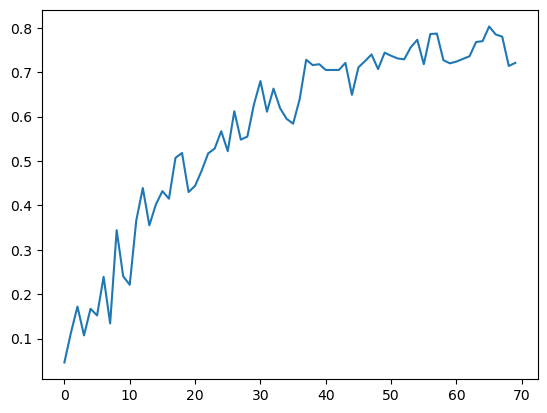

In [12]:
plot(res_hist_test)
plt.show()

In [13]:
#W=Srs.w.data.copy().reshape(N_v+N_c, N_h)*beta
W = np.array(Srs.w).reshape(N_v+N_c, N_h)*beta
Wvh=W[:N_v,:]
Wch=W[N_v:,:]
#mBv = Sbv.w.data*beta*tau_rec*bias_input_rate
mBv = np.array(Sbv.w)*beta*tau_rec*bias_input_rate
#mBh = Sbh.w.data*beta*tau_rec*bias_input_rate
mBh = np.array(Sbh.w)*beta*tau_rec*bias_input_rate
b_c = mBv[N_v:(N_v+N_c)]
b_v = mBv[:N_v]
b_h = mBh
mB = np.concatenate([mBv,mBh])

Other thing with generative model demonstration: 

In [14]:
data =  mnist_data = load_MNIST(1,
                            min_p = 1e-4,
                            max_p = .9999,
                            binary = True,
                            seed = None)

def create_single_Id(idx, data, min_p = 1e-16, max_p = .9999, seed = None, mult_class=0.0, mult_data=1.0):
    
    iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = data
    Idp = np.ones([N_v+N_c])*min_p
    i = np.nonzero(iv_l_seq==idx)[0][0]
    cl = np.zeros(N_c)
    cl[int(iv_l_seq[i]*n_c_unit):int((iv_l_seq[i]+1)*n_c_unit)] = max_p
    Idp[N_v:] = clamped_input_transform(cl, min_p = min_p, max_p = max_p)*mult_class
    Idp[:N_v] = clamped_input_transform(iv_seq[i,:], min_p = min_p, max_p = max_p)*mult_data
    Id = (Idp /beta)
    return Id

In [15]:
def exp_prob_beta_gamma(dt, beta, g_leak, gamma, t_ref):
    def func(V):
        return np.random.rand( len(V) ) < (1-np.exp(-np.exp(V*beta*g_leak+np.log(gamma))*float(dt)))
    return func

         
def custom_step(clock_object):
    tmod_now, n_now = clock_object.tmod, clock_object.n
    clock_object.tmod = np.mod(clock_object.tmod+1, clock_object.mod)
    clock_object.n = int(clock_object.t/(clock_object.period))
    return tmod_now, n_now

sigm = lambda x: 1./(1+exp(-x))
#helper parameters

Bu = 10.0
wb = 10.5
N_helper=100

In [16]:
#Mh, Mv, Mc, Mhelp = run_NS(5)
hacked_digit = create_single_Id(8,data,mult_class=0.0,mult_data=1.0)
hacked_digit[:N_v].reshape(28,28)[:,:14] = 0.
cl = np.zeros(N_c)
cl[(3*int(n_c_unit)):(4*int(n_c_unit))] = .98
cl[(6*int(n_c_unit)):(7*int(n_c_unit))] = .98
hacked_digit[N_v:]= clamped_input_transform(cl, min_p = 1e-16, max_p = .500+.2e-9)

Second Parameters

In [17]:
# Parameters demo: 
n_classes = 10
N_v = N_inputs =784
N_c = N_class = 40
N_h = N_hidden =500

n_c_unit =  N_c/n_classes

dcmt = 75 #duty cyle in multiples of t_ref

#----------------------------------------- Neuron parameters
t_ref = 0.004 * second

T = dcmt*t_ref
init_delay=dcmt*t_ref
delay=0*ms
T1_s = init_delay
T1_e = T+init_delay
T2_s = T+init_delay+delay
T2_e = 2*T+delay+init_delay
T3_s = 2*T+2*delay+ init_delay
T3_e = 3*T+2*delay+ init_delay

t_sim = T3_e

t_ref = 0.004 * second
bias_input_rate = 1000. * Hz # added Hz
beta = 2.04371561e+09
gamma = np.exp(9.08343441e+00) * Hz # added Hz
tau_noise = .001 * second
tau_rec = t_ref
theta = .1 * volt
cm = 1e-12 * farad
beta_fi = 1./cm/theta
sigma = 1.e-9 * amp
cal_i_lk = 0.0e-10
g_leak = 1e-9 * siemens
dt = 0.00005
n_samples = t_sim/(dcmt*t_ref)+1
wnsigma = 4.24e-11

t_burn_percent = 10.
tau_learn = 0.01 * second

deltaT = ((0.49-t_burn_percent/100)*dcmt*t_ref)

eta = 0e-3
epsilon = eta/beta*t_ref**2*(dcmt*t_ref)/deltaT
epsilon_bias = eta/beta*t_ref*(1./bias_input_rate)*(dcmt*t_ref)/deltaT

deltaA  = eta/beta/tau_learn*(dcmt*t_ref)/deltaT*t_ref**2 / second
deltaAbias = eta/beta/tau_learn*(dcmt*t_ref)/deltaT*t_ref*(1./bias_input_rate) / second

i_inj = (- np.log(float(gamma))
         - np.log(float(t_ref))
         )/beta * amp

sigm = lambda x: 1./(1+exp(-x))
#helper parameters

Bu = 3.2 * Hz
wb = 12.5
N_helper=100
         
         
def exp_prob_beta_gamma(dt, beta, g_leak, gamma, t_ref):
    def func(V):
        return np.random.rand( len(V) ) < (1-np.exp(-np.exp(V*beta*g_leak+np.log(gamma))*float(dt)))
    return func

def learning_rate_decay(n,n0=1):
    return float(n0)/(float(n0)+n)

         

In [18]:
Th = Bu * wb
i_inj_v_helper =  Th/beta_fi
i_inj_v_helper


4. * pamp

In [19]:
eqs_str_lif_wnrd = '''
dv/dt = (-g*v + I_inj + I_rec + sigma*xi*t_ref**0.5 + I_d)/Cm :volt
dI_rec/dt = -I_rec/tau_rec : amp
I_d : amp
'''

eqs_str_lif_wnr = '''
dv/dt = (-g_leak*v + i_inj + I_rec + sigma*xi*t_ref**0.5)/Cm :volt
dI_rec/dt = -I_rec/tau_rec : amp
'''

In [20]:
# Main2: 
def main(Whv, b_v, b_c, b_h, Id, dorun = True, monitors=True, display=False, mnist_data = None):
    start_scope()
    b_init = np.concatenate([b_v, b_c, b_h])
    netobjs = []

    Wh = Whv[:(N_v),:]
    b1 = (sigm(b_v)).mean() #0.47174785699167904
    b2 = (sigm(b_h)).mean() #0.55992711057515843
    Th = Bu * wb
    A = -np.log((-1+1./(t_ref*Bu))*gamma*t_ref)
    wmean = np.mean(Wh)#-0.023632872766664939
    wh = (A - wmean*b1 - b_h.mean())/Th
    wv = (A - wmean*b2 - b_v.mean())/Th
    N_helper = 25
    i_inj_v_helper =  Th/beta_fi
    i_inj_h_helper =  Th/beta_fi

    #------------------------------------------ Neuron Groups
    print("Creating equation")
    
    eqs_v = Equations(eqs_str_lif_wnrd, 
            Cm = 1e-12*farad,
            I_inj = i_inj,
            g = g_leak,
            sigma = sigma,
            tau_rec = tau_rec)
                                               
    eqs_h = Equations(eqs_str_lif_wnr, 
            Cm = 1e-12*farad,
            I_inj = i_inj,
            g = g_leak,
            sigma = sigma,
            tau_rec = tau_rec)

    eqs_v_helper = Equations(eqs_str_lif_wnr, 
            Cm = 1e-12*farad,
            I_inj = i_inj_v_helper,
            g = 0. * siemens,
            sigma = 0. * amp,
            tau_rec = tau_rec)
                                               
    eqs_h_helper = Equations(eqs_str_lif_wnr, 
            Cm = 1e-12*farad,
            I_inj = i_inj_h_helper,
            g = 0. * siemens,
            sigma = 0. * amp,
            tau_rec = tau_rec)
    
    neuron_group_rvisible = NeuronGroup(\
            N_v+N_c,
            model = eqs_v,
            threshold = 'v>theta', # removed: *volt
            refractory = t_ref,
            reset = "v = 0 * volt"
            )
    
    neuron_group_rhidden = NeuronGroup(\
            N_h,
            model = eqs_h,
            threshold = 'v>theta', # removed: *volt
            refractory = t_ref,
            reset = "v = 0*volt"
            )

    neuron_group_rvisible_helper = NeuronGroup(\
            N_helper,
            model = eqs_v_helper,
            threshold = 'v>theta', # removed: *volt
            reset = "v = 0*volt"
            )
    
    neuron_group_rhidden_helper = NeuronGroup(\
            N_helper,
            model = eqs_h_helper,
            threshold = 'v>theta', # removed: *volt
            reset = "v = 0*volt"
            )

    neuron_group_rvisible_helper.v = np.random.uniform(0,1,size=N_helper) * volt
    neuron_group_rhidden_helper.v = np.random.uniform(0,1,size=N_helper) * volt

    netobjs += [neuron_group_rvisible, neuron_group_rhidden, neuron_group_rvisible_helper, neuron_group_rhidden_helper]
    
    @network_operation(clock=defaultclock)
    def update_mpot_helper(when='after'):
        neuron_group_rvisible_helper.v[neuron_group_rvisible_helper.v<=0.0*volt]=0.0*volt
        neuron_group_rhidden_helper.v[neuron_group_rhidden_helper.v<=0.0*volt]=0.0*volt

    netobjs += [update_mpot_helper]
    #--------------------------- Custom Network Operations

    
    #Bias group
    Bv = PoissonGroup(N_v+N_c, rates = bias_input_rate) #Noise injection to h
    Bh = PoissonGroup(N_h, rates = bias_input_rate) #Noise injection to h
    
    netobjs+=[Bv,Bh]
    
    #---------------------- Initialize State Variables
    neuron_group_rvisible.I_d = 0.
    
    
    #---------------------- Connections and Synapses
    #Bias units    
    Sbv = Synapses(Bv, neuron_group_rvisible, 
              model='''
                Apre : 1
                Apost : 1
                g : 1
                w : 1
                lastupdate : second''', 
            on_pre =''' Apre = Apre * exp((lastupdate-t)/tau_learn)
                        Apost = Apost * exp((lastupdate-t)/tau_learn)
                        Apre += deltaAbias
                        w = w + g * Apost
                        I_rec_post += w * amp
                        lastupdate = t''', 
            on_post=''' Apre = Apre*exp((lastupdate-t)/tau_learn)
                        Apost = Apost*exp((lastupdate-t)/tau_learn)
                        Apost += deltaAbias
                        w=w+g*Apre
                        lastupdate = t''' 
                        )
    Sbv.connect(j='i')
    Sbv.w[:] = np.concatenate([b_v,b_c])/beta/bias_input_rate/tau_rec
    
    Sbh = Synapses(Bh, neuron_group_rhidden, 
              model='''
                Apre : 1
                Apost : 1
                g : 1
                w : 1
                lastupdate : second''', 
            on_pre =''' Apre = Apre * exp((lastupdate-t)/tau_learn)
                        Apost = Apost * exp((lastupdate-t)/tau_learn)
                        Apre += deltaAbias
                        w = w + g * Apost
                        I_rec_post += w * amp
                        lastupdate = t''', 
            on_post=''' Apre = Apre*exp((lastupdate-t)/tau_learn)
                        Apost = Apost*exp((lastupdate-t)/tau_learn)
                        Apost += deltaAbias
                        w=w+g*Apre
                        lastupdate = t''' 
                        )
    Sbh.connect(j='i')
    Sbh.w[:] = b_h[:]/beta/bias_input_rate/tau_rec
    
    Srs=Synapses(neuron_group_rvisible, neuron_group_rhidden,
           model='''   Apre : 1
                Apost : 1
                g : 1
                w : 1
                lastupdate : second''', 
        on_pre =''' Apre = Apre*exp((lastupdate-t)/tau_learn)
                    Apost = Apost*exp((lastupdate-t)/tau_learn)
                    Apre += deltaA
                    I_rec_post += w * amp
                    w = w + g * Apost
                    lastupdate = t''', 
        on_post=''' Apre = Apre * exp((lastupdate-t)/tau_learn)
                    Apost = Apost * exp((lastupdate-t)/tau_learn)
                    Apost += deltaA
                    I_rec_pre += w * amp
                    w = w + g * Apre
                    lastupdate = t''' 
                )
    Srs.connect()
    
    M_rec = Whv/beta
    for i in range(M_rec.shape[0]):
        Srs.w[i,:] = M_rec[i,:]

    #S_helper_v = Connection(neuron_group_rvisible_helper, neuron_group_rvisible, 'I_rec')
    S_helper_v = Synapses(neuron_group_rvisible_helper, neuron_group_rvisible, 
                          "w : 1",
                          on_pre='I_rec += w * amp') # added * amp
    #S_helper_v.connect_random(neuron_group_rvisible_helper, neuron_group_rvisible, p=0.5, weight = -wv/N_helper/.5/beta/tau_rec)
    S_helper_v.connect(p=0.5)
    S_helper_v.w = -wv/N_helper/.5/beta/tau_rec
    S_helperi_v = Synapses(neuron_group_rvisible, neuron_group_rvisible_helper, 
                           on_pre = "I_rec_post+= -wb/.5/N_v/beta_fi/tau_rec")
    #S_helperi_v.connect_random(neuron_group_rvisible, neuron_group_rvisible_helper,sparseness=0.5)
    S_helperi_v.connect(p=0.5)
    S_helper_h = Synapses(neuron_group_rhidden_helper, neuron_group_rhidden,
                          "w : 1",
                          on_pre='I_rec += w * amp')  # added * amp
    S_helper_h.connect(p=0.5)
    S_helper_h.w = -wh/N_helper/.5/beta/tau_rec

    S_helperi_h = Synapses(neuron_group_rhidden, neuron_group_rhidden_helper, 
                          "w : 1",
                          on_pre='I_rec += w * amp')  # added * amp
    S_helperi_h.connect(p=0.5) 
    S_helperi_h.w = -wb/.5/N_h/beta_fi/tau_rec / amp
    
    netobjs+= [Sbv,Sbh,Srs,S_helperi_v,S_helperi_h,S_helper_v,S_helper_h]

    period = dcmt*t_ref
    mod = 100
    ev = Clock(period/mod)
    ev.add_attribute(name = "n")
    ev.add_attribute(name = "tmod")
    ev.add_attribute(name = "mod")
    ev.add_attribute(name = "period")
    ev.n = 0
    ev.tmod = 0
    ev.mod = mod
    ev.period = period

    @network_operation(clock = ev)
    def g_update(when='after'):
        tmod, n = custom_step(ev)
        if tmod < 50:
            neuron_group_rvisible.I_d = Id[n]  * amp
        else:
            neuron_group_rvisible.I_d = Id[n]  * amp
    
        if tmod<=int(t_burn_percent):
            Srs.g = 0.
            Sbh.g = Sbv.g = 0.

        elif int(t_burn_percent)<=tmod<49:
            g_up = 1.
            Srs.g = Sbv.g = Sbh.g =  learning_rate_decay(n,n0=4000)*g_up
            
        elif 49<=tmod < 50+int(t_burn_percent):
            Srs.g = Sbv.g = Sbh.g = +0.
            
        elif 50+int(t_burn_percent) <= tmod <99:
            g_down = -1.
            Srs.g = Sbv.g = Sbh.g = learning_rate_decay(n,n0=4000)*g_down
            
        elif 99<= tmod:
            Srs.g = 0.
            Sbh.g = Sbv.g = 0.
    
#        if tmod==50:
#            #neuron_group_rvisible.I_DATA=0
#            Srs.Afre=0
#            Srs.Afost=0
#            Sbv.Afre=0
#            Sbv.Afost=0
#            Sbh.Afre=0
#            Sbh.Afost=0

    netobjs += [g_update]
        
    w_hist_v = []
    w_hist_c = []
    b_hist_vc = []
    b_hist_h = []
    
    if display:
        iv_seq, iv_l_seq, train_iv, train_iv_l, test_iv, test_iv_l = mnist_data
        figure()
        res_hist_test=[]
        res_hist_train=[]
        test_data = test_iv
        test_labels = test_iv_l
        train_data = train_iv[:200]
        train_labels = train_iv_l[:200]
        plot_every = 10
        
        @network_operation(clock=Clock(dt=plot_every*dcmt*t_ref))
        def plot_performance(when='after'):    
            n = ev.n
            Wt = Srs.w.data.reshape(N_v+N_c,N_h)
            w_hist_v.append(Wt[:N_v,:].mean())
            w_hist_c.append(Wt[N_v:,:].mean())
            b_hist_vc.append(Sbv.w.data.mean())
            b_hist_h.append(Sbh.w.data.mean())
            W=Srs.w.data.copy().reshape(N_v+N_c, N_h)*beta
            Wvh=W[:N_v,:]
            Wch=W[N_v:,:]
            mBv = Sbv.w.data*beta*tau_rec*bias_input_rate
            mBh = Sbh.w.data*beta*tau_rec*bias_input_rate
            b_c = mBv[N_v:(N_v+N_c)]
            b_v = mBv[:N_v]
            b_h = mBh
            mB = np.concatenate([mBv,mBh])
    
        
            accuracy_test = classification_free_energy(Wvh, Wch, b_h, b_c, test_data, test_labels, n_c_unit)[0]    
            res_hist_test.append(accuracy_test)
            
        
            accuracy_train = classification_free_energy(Wvh, Wch, b_h, b_c, train_data, train_labels, n_c_unit)[0]
            res_hist_train.append(accuracy_train)
        
            clf()
            plot(res_hist_train, 'go-', linewidth=2)
            plot(res_hist_test, 'ro-', linewidth=2)
            axhline(0.1)
            axhline(0.85)
            axhline(0.9, color='r')
            xlim([0,t_sim/(plot_every*dcmt*t_ref)])
            ylim([0.0,1])
            a=plt.axes([0.7,0.1,0.2,0.2])
            a.plot(w_hist_v,'b.-')
            a.plot(w_hist_c,'k.-')
            a.plot(b_hist_vc,'g.-')
            a.plot(b_hist_h,'r.-')
        
            print(accuracy_test)
            draw()
        
        netobjs += [plot_performance]
    
    #--------------------------- Monitors
    if monitors:
        Mh=SpikeMonitor(neuron_group_rhidden)
        Mv=SpikeMonitor(neuron_group_rvisible[:N_v])
        Mc=SpikeMonitor(neuron_group_rvisible[N_v:])
        Mvmem=StateMonitor(neuron_group_rvisible[N_v:], variables='v', record=True, )
        netobjs += [Mh, Mv, Mc, Mvmem]
    #MId = StateMonitor(neuron_group_rvisible, varname='I_d', record=True)
    #MIt = StateMonitor(Sbh,varname='g',record=[0])
    net = Network(netobjs)
    if dorun:
        import time
        tic = time.time()      
        net.run(t_sim)
        toc = time.time()-tic
        print(toc)
        
    return locals()

In [21]:
hacked_digit = create_single_Id(8,data,mult_class=0.0,mult_data=1.0)
hacked_digit[:N_v].reshape(28,28)[:,:14] = 0.
cl = np.zeros(N_c)
cl[int(3*n_c_unit):int(4*n_c_unit)] = .98
cl[int(6*n_c_unit):int(7*n_c_unit)] = .98
hacked_digit[N_v:]= clamped_input_transform(cl, min_p = 1e-16, max_p = .500+.2e-9)

Ids_demo = np.load('data/ids.npy')
Ids = np.column_stack([
    create_single_Id(3,data,mult_class=0.0,mult_data=1.0)*0,
    create_single_Id(3,data,mult_class=0.0,mult_data=1.0),
    create_single_Id(5,data,mult_class=1.0,mult_data=0.0),
    hacked_digit,
    ]).T

Ids[-1,:N_v] = Ids_demo[-1,:N_v]
Ids[1,:N_v] = Ids_demo[1,:N_v]

In [30]:
out = main(W, b_v, b_c, b_h, Id = Ids, display=False, monitors=True)
Mh, Mv, Mc= out['Mh'], out['Mv'], out['Mc']

WARNING    'i' is an internal variable of group 'synapses_10', but also exists in the run namespace with the value 823. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'i' is an internal variable of group 'synapses_11', but also exists in the run namespace with the value 823. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]


Creating equation


INFO       No numerical integration method specified for group 'neurongroup_6', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_7', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_8', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
INFO       No numerical integration method specified for group 'neurongroup_9', using method 'euler' (took 0.00s, trying other methods took 0.00s). [brian2.stateupdaters.base.method_choice]
WARNING    'dt' is an internal variable of group 'poissongroup_4', but also exists in the run namespace with the value 5e-05. The internal variable will be used. [brian2.groups.group.Group.resolve.resolution_conflict]
WARNING    'dt' is an 

3.857891082763672


In [31]:


""" d = et.mksavedir()
et.globaldata.Mc = Mc.spikes
et.globaldata.Mv = Mv.spikes
et.globaldata.Mh = Mh.spikes
et.save()
 """

' d = et.mksavedir()\net.globaldata.Mc = Mc.spikes\net.globaldata.Mv = Mv.spikes\net.globaldata.Mh = Mh.spikes\net.save()\n '

In [32]:
def spike_histogram(spike_monitor, t_start, t_stop):
    '''
    Returns firing rate of spike_monitor between t_start and t_stop
    '''
    import numpy as np
    delta_t = t_stop - t_start
    k, v = zip(*spike_monitor.spike_trains().items())   
    def f(s):
        idx_low = s >= t_start
        idx_high = s < t_stop
        idx = idx_low * idx_high
        return np.sum(idx)
    count = np.array(list(map(f, v)), dtype='float')/delta_t
    return np.array(list(zip(*[k,count])))

In [33]:

#from plot_options import *
#pylab.ioff()


bone()
matplotlib.rcParams['figure.subplot.wspace']=.0
matplotlib.rcParams['figure.subplot.hspace']=.0
matplotlib.rcParams['figure.subplot.bottom']=.0
matplotlib.rcParams['figure.subplot.left']=.0
matplotlib.rcParams['figure.subplot.right']=1.0
matplotlib.rcParams['figure.subplot.top']=1.0
f1=np.array(spike_histogram(Mv,T1_s+10*t_ref,T1_e)).T[1].reshape(28,28)


<Figure size 640x480 with 0 Axes>

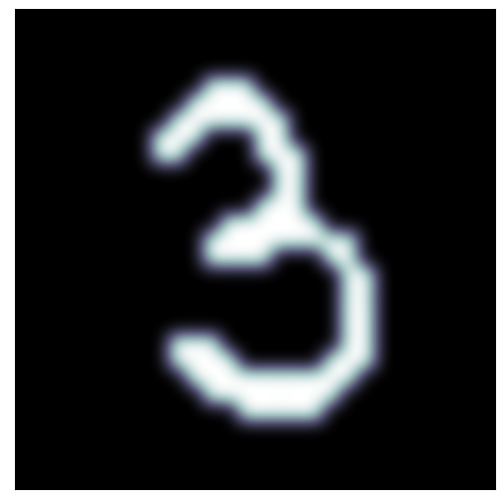

In [34]:
#figure()
#imshow(f1, interpolation = 'bicubic'); xticks([]), yticks([])
#et.savefig('pre_trained_prediction.png', format = 'png')

fig, ax = plt.subplots()
ax.imshow(f1, interpolation = 'bicubic'); xticks([]), yticks([]
        )
plt.show()


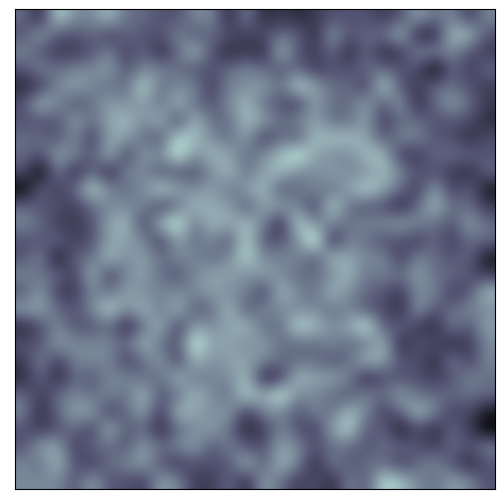

In [35]:

f2=np.array(spike_histogram(Mv,T2_s+60*t_ref,T2_e)).T[1].reshape(28,28)
#figure(); imshow(f2, interpolation = 'bicubic'); xticks([]), yticks([])
#et.savefig('pre_trained_construction.png', format = 'png')

fig, ax = plt.subplots()
ax.imshow(f2, interpolation = 'bicubic'); xticks([]), yticks([]
        )
plt.show()

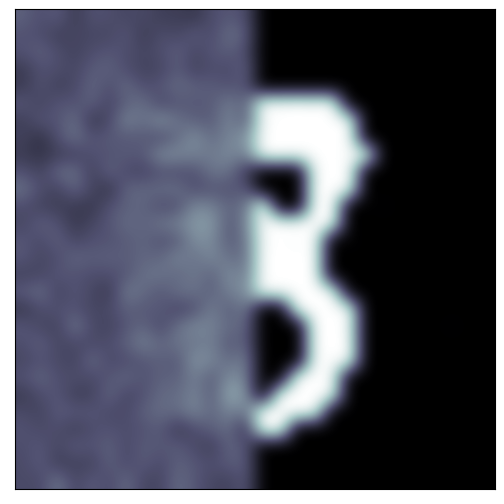

In [36]:

f3=np.array(spike_histogram(Mv,T3_s+15*t_ref,T3_e)).T[1].reshape(28,28)
#figure(); imshow(f3, interpolation = 'bicubic'); xticks([]), yticks([])
#axvline(14,color = 'w', linewidth=3, alpha=0.8)
#et.savefig('pre_trained_inference.png', format = 'png')

fig, ax = plt.subplots()
ax.imshow(f3, interpolation = 'bicubic'); xticks([]), yticks([]
        )
plt.show()

In [29]:
figure(figsize=(12.0, 4.5))
matplotlib.rcParams['figure.subplot.bottom']=.17
matplotlib.rcParams['figure.subplot.left']=.04
matplotlib.rcParams['figure.subplot.right']=.90
matplotlib.rcParams['figure.subplot.top']=.95
raster_plot(Mv, Mc,newfigure=False,markersize=2,marker='|', color='k',mew=1)
xt = xticks()[0]
axhline(1, color='k', linewidth=2, alpha=0.8)
axhline(2, color='k', linewidth=2, alpha=0.8)
for i in range(n_classes):
    axhline(1+float(i)/10, color='k')

axhline(2, color='k', linewidth=2, alpha=0.8)
axvline(T1_s*1000, color='k')
axvline(T1_e*1000, color='k')
axvline(T2_s*1000, color='k')
axvline(T2_e*1000, color='k')
axvline(T3_s*1000, color='k')
axvline(T3_e*1000, color='k')
yticks([.5, 1.5],['$v_d$','$v_c$'])
xlabel('Time[s]')
ylabel('')
ax = gca().twinx()
xt = np.array([0,round(T1_s),round(T2_s),round(T3_s,1)])
xticks((xt+init_delay)*1000, xt) 
xlim([.1*1000,t_sim*1000-40])
ylim([0,3])
yticks(np.arange(1.05,2.0,.2), ['${0}$'.format(i) for  i in range(0,10,2)], fontsize=22)
et.savefig('pretrained_raster_all.png', format='png')

matplotlib.rcParams['figure.subplot.left']=.25
matplotlib.rcParams['figure.subplot.right']=.94
figure(figsize=(6.0,4.0))
Sh=monitor_to_spikelist(Mh).time_slice(0,t_sim*1000)
Sv=monitor_to_spikelist(Mv).time_slice(0,t_sim*1000)
Sc=monitor_to_spikelist(Mc).time_slice(0,t_sim*1000)
Sh.time_offset(-init_delay*1000)
Sv.time_offset(-init_delay*1000)
Sc.time_offset(-init_delay*1000)
tbin = 10
labello = ['$v_d$', '$h$', '$v_c$']
for i, S in enumerate([Sv, Sh, Sc]):
    plot(S.time_axis(tbin)[:-1], S.spike_histogram(time_bin=tbin, normalized=True).mean(axis=0), '.-' , linewidth=2,label = labello[i], markersize=7)
axvline(T1_s*1000-init_delay*1000, color='k')
axvline(T1_e*1000-init_delay*1000, color='k')
axvline(T2_s*1000-init_delay*1000, color='k')
axvline(T2_e*1000-init_delay*1000, color='k')
axvline(T3_s*1000-init_delay*1000, color='k')
axvline(T3_e*1000-init_delay*1000, color='k')
xlim([-.2*1000,t_sim*1000-init_delay*1000])
xticks((xt)*1000, xt) 
ylabel('Firing rate [Hz]')
ylim([0,100])
legend(labelspacing=0, ncol=3, frameon=1, borderpad=0, borderaxespad=0, columnspacing=.1, handletextpad=0)
gca().add_patch(Rectangle((0,1), 10*t_ref*1000, 2.5, fill=True, color='k'))
et.savefig('pretrained_rates.png', format='png')

#    xt = np.array([0,0.1,0.2,0.3,.85])
#    figure(figsize = (8,6))
#    colorlist = ['b','b','b','r','b','b','b','b','b','b']
#    for i in range(10): plot(out['Mvmem'].times[0:T1_e*10000], i+ 0.75*out['Mvmem'].values[2+i*4,0:T1_e*10000], color=colorlist[i])
#    xticks((xt+init_delay), xt)
#    axvline(0.0)
#    xlim([0,T1_e])
#
#    figure(figsize = (8,6))
#    raster_plot(Mv, Mc,newfigure=False,markersize=4,marker='.')
#    axhline(1, color='k', linewidth=2, alpha=0.8)
#    axhline(2, color='k', linewidth=2, alpha=0.8)
#    for i in range(n_classes):
#        axhline(1+float(i)/10, color='k')
#
#    axhline(2, color='k', linewidth=2, alpha=0.8)
#    axvline(T1_s*1000, color='k')
#    axvline(T1_e*1000, color='k')
#    axvline(T2_s*1000, color='k')
#    axvline(T2_e*1000, color='k')
#    axvline(T3_s*1000, color='k')
#    axvline(T3_e*1000, color='k')
#    yticks([.5, 1.5],['$v_{d}$','$v_{c}$'])
#    xlabel('Time[s]')
#    ylabel('')
#    ax = gca().twinx()
#    xlim([0,T1_e*1000])
#    xlabel('')
#    xticks((xt+init_delay)*1000, xt) 
#    ylim([0,3])
#    yticks([])

show()


NameError: name 'raster_plot' is not defined

<Figure size 1200x450 with 0 Axes>